# Progetto Applicazioni Data Intensive 2023
## Anomaly detection in Air Production Unit (APU) of a metro

#### Autori: Alessandro Sciarrillo e Niccolò Mussoni

In [1]:
import datetime
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image
import sklearn
import xgboost
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
from sklearn.tree import export_graphviz
from subprocess import call
from scipy import stats
from copy import deepcopy
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

## Contesto e Obbiettivo del modello

### Obiettivo
L'obbiettivo del progetto è di ottenere un modello di classificazione binaria in grado di riconoscere in base ai dati rilevati dai sensori di una APU di un treno della metro se si sta verificando un'anomalia. </br>
Il risultato di questa classificazione può avere rilevanza nell'ambito dall'Industria 4.0, in particolare il modello finale del progetto è volto soprattutto ad essere collocato nel contesto dell'**Anomaly Detection** ma può anche essere utilizzato nell'ambito della manutenzione preventiva con i dovuti accorgimenti.

### Dataset

Il dataset (1) raccoglie le misurazioni effettuate dall'Air Production Unit (APU) di un treno nella metro di Porto. Ci concentriamo su una serie di sensori analogici e digitali installati sul treno.
Le misurazioni dei sensori sono state raccolte da Febbraio a Settembre 2020, con un intervallo temporale di 10 secondi tra loro, dove i 15 segnali sono raccolti da un dispositivo embedded a bordo che è capace di trasferire i dati al server usando il protocollo TCP/IP.

(1): https://archive.ics.uci.edu/dataset/791/metropt+3+dataset

In [2]:
file_zip_url = "https://archive.ics.uci.edu/static/public/791/metropt+3+dataset.zip"
file_zip_name = "metropt+3+dataset.zip"
file_data_set_name = "MetroPT3(AirCompressor).csv"

if not os.path.exists(file_zip_name):
    from urllib.request import urlretrieve
    urlretrieve(file_zip_url, file_zip_name)
    from zipfile import ZipFile
    with ZipFile(file_zip_name) as f:
        f.extractall()

# specifichiamo tipi di dato per ottimizzare lo spazio occupato
types = {
    "COMP":             np.uint8,
    "DV_eletric":       np.uint8,
    "Towers":           np.uint8,
    "MPG":              np.uint8,
    "LPS":              np.uint8,
    "Pressure_switch":  np.uint8,
    "Oil_level":        np.uint8,
    "Caudal_impulses":  np.uint8
}

df_full = pd.read_csv(file_data_set_name, sep=",", dtype=types, parse_dates=["timestamp"])

df_full.head()

,Unnamed: 0,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses
0,0,2020-02-01 00:00:00,-0.012,9.358,9.340,-0.024,9.358,53.600,0.0400,1,0,1,1,0,1,1,1
1,10,2020-02-01 00:00:10,-0.014,9.348,9.332,-0.022,9.348,53.675,0.0400,1,0,1,1,0,1,1,1
2,20,2020-02-01 00:00:19,-0.012,9.338,9.322,-0.022,9.338,53.600,0.0425,1,0,1,1,0,1,1,1
3,30,2020-02-01 00:00:29,-0.012,9.328,9.312,-0.022,9.328,53.425,0.0400,1,0,1,1,0,1,1,1
4,40,2020-02-01 00:00:39,-0.012,9.318,9.302,-0.022,9.318,53.475,0.0400,1,0,1,1,0,1,1,1


### Prima fase di pulizia dei dati

Rimuoviamo la prima colonna, in quanto contiene degli identificatori non informativi per il nostro scopo, estraiamo anche il timestamp poichè non vogliamo che la predizione dipenda da esso e lo impostiamo come indice.

In [3]:
df = df_full.drop(df_full.columns[[0]], axis=1)
df.set_index(["timestamp"],  inplace=True)
df.head()

,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses
timestamp,,,,,,,,,,,,,,,
2020-02-01 00:00:00,-0.012,9.358,9.340,-0.024,9.358,53.600,0.0400,1,0,1,1,0,1,1,1
2020-02-01 00:00:10,-0.014,9.348,9.332,-0.022,9.348,53.675,0.0400,1,0,1,1,0,1,1,1
2020-02-01 00:00:19,-0.012,9.338,9.322,-0.022,9.338,53.600,0.0425,1,0,1,1,0,1,1,1
2020-02-01 00:00:29,-0.012,9.328,9.312,-0.022,9.328,53.425,0.0400,1,0,1,1,0,1,1,1
2020-02-01 00:00:39,-0.012,9.318,9.302,-0.022,9.318,53.475,0.0400,1,0,1,1,0,1,1,1


### Variabili
Visualizziamo un immagine del sistema Air Production Unit con le posizioni dei sensori principali:
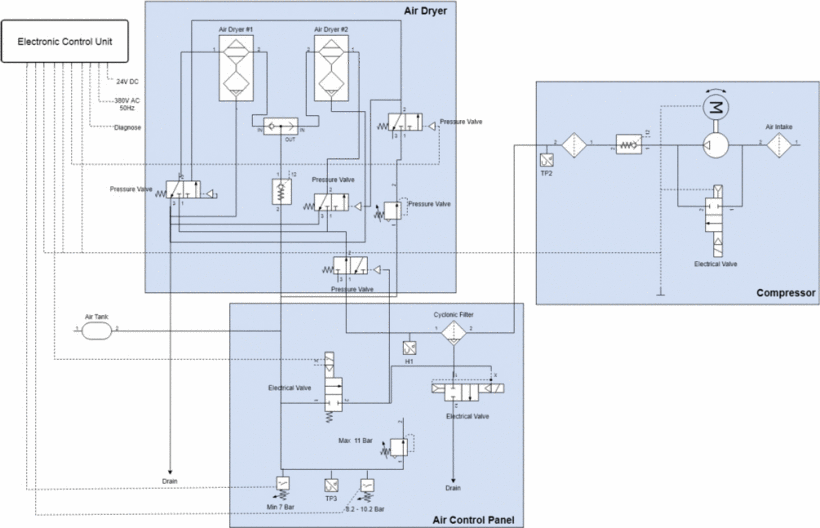

#### Valori analogici
- **`TP2`**: pressione del compressore [bar]
- **`TP3`**: pressione generata nel pannello pneumatico [bar]
- **`H1`**: pressione generata a causa di un calo di pressione quando avviene una scarica del filtro separatore ciclonico [bar]
- **`DV_pressure`**: misura del calo di pressione generato quando le torri scaricano gli essiccatori d'aria [bar]
- **`Reservoirs`**: pressione sul fondo dei serbatoi [bar]
- **`Motor_Current`**: corrente di una fase del motore trifase [A]
    - 0A - spento
    - 4A - assenza di carico
    - 7A - sotto carico
    - 9A - in funzione
- **`Oil_Temperature`**: temperatura dell'olio nel compressore [°C]

#### Valori digitali
- **`COMP`**: segnale della valvola di aspirazione dell'aria nel compressore
    - acceso quando non viene aspirata aria, indicando che il compressore è spento o sta lavorando in assenza di carico
- **`DV_eletric`**: segnale che controlla la valvola di scarico del compressore
    - spento se il compressore è spento o sta lavorando in assenza di carico
- **`TOWERS`**: segnale che indica quale torre responsabile dell'umidità dell'aria sta lavorando
    - se spento sta lavorando la prima torre, quella responsabile dell'essicatura dell'aria
    - se acceso sta lavorando la seconda torre, quella responsabile del rilascio dell'umidità rimossa dall'aria
- **`MPG`**: segnale che accende il compressore sotto carico attivando la valvola di aspirazione quando la pressione nell'APU scende sotto 8.2 bar. Attiva il sensore COMP, che ha lo stesso comportamento
- **`LPS`**: segnale che si accende quando la pressione scende sotto 7 bar
- **`Pressure Switch`**: segnale che rileva la fase di scarico nelle torri di essicazione
- **`Oil_Level`**: segnale che rileva il livello dell'olio nel compressore
    - acceso quando il livello dell'olio è sotto i valori attesi
- **`Caudal_Impulse`**: segnale che conta gli impulsi generati dall'aria che va dall'APU ai serbatoi.

### Integrazione con periodi di anomalia verificati

Dal paper (2) che ha raccolto questi dati abbiamo ricavato gli intervalli di data-ora in cui un esperto ha determinato se ci fossero state anomalie nell'APU, comprese nel periodo da Aprile a Luglio 2020.

Definiamo quindi una nuova varibile binaria **`Anomaly`** che assumerà valore 1 per le istanze appartenti ad un lasso di tempo contrassegnato come anomalo, altrimenti 0.

(2): https://ieeexplore.ieee.org/document/9564181

In [4]:
df["Anomaly"] = 0

def set_anomaly(anomaly_intervals):
    anomaly = df["Anomaly"].copy()
    for s, e in anomaly_intervals:
        start = [int(st) for st in s.split(',')]
        end   = [int(en) for en in e.split(',')]
        anomaly_interval = (df.index >= datetime.datetime(*start)) & (df.index <= datetime.datetime(*end))
        anomaly[anomaly_interval] = 1

    df["Anomaly"] = anomaly

anomaly_intervals = [
    ('2020,4,12,11,50, 0',   '2020,4,12,23,30, 0'),
    ('2020,4,18, 0, 0, 0',   '2020,4,18,23,59, 0'),
    ('2020,4,19, 0, 0, 0',   '2020,4,19, 1,30, 0'),
    ('2020,4,29, 3,20, 0',   '2020,4,29, 4, 0, 0'),
    ('2020,4,29,22, 0, 0',   '2020,4,29,22,20, 0'),
    ('2020,5,13,14, 0, 0',   '2020,5,13,23,59, 0'),
    ('2020,5,18, 5, 0, 0',   '2020,5,18, 5,30, 0'),
    ('2020,5,19,10,10, 0',   '2020,5,19,11, 0, 0'),
    ('2020,5,19,22,10, 0',   '2020,5,19,23,59, 0'),
    ('2020,5,20, 0, 0, 0',   '2020,5,20,20, 0, 0'),
    ('2020,5,23, 9,50, 0',   '2020,5,23,10,10, 0'),
    ('2020,5,29,23,30, 0',   '2020,5,29,23,59, 0'),
    ('2020,5,30, 0, 0, 0',   '2020,5,30, 6, 0, 0'),
    ('2020,6, 1,15, 0, 0',   '2020,6, 1,15,40, 0'),
    ('2020,6, 3,10, 0, 0',   '2020,6, 3,11, 0, 0'),
    ('2020,6, 5,10, 0, 0',   '2020,6, 5,23,59, 0'),
    ('2020,6, 6, 0, 0, 0',   '2020,6, 6,23,59, 0'),
    ('2020,6, 7, 0, 0, 0',   '2020,6, 7,14,30, 0'),
    ('2020,7, 8,17,30, 0',   '2020,7, 8,19, 0, 0'),
    ('2020,7,15,14,30, 0',   '2020,7,15,19, 0, 0'),
    ('2020,7,17, 4,30, 0',   '2020,7,17, 5,30, 0')
]

set_anomaly(anomaly_intervals)

beginning_of__anomaly = (df.index > datetime.datetime(2020, 5, 18, 4, 59, 0)) & (df.index <= datetime.datetime(2020, 5, 18, 5, 1, 0))
df[beginning_of__anomaly].loc[:, "Anomaly":]

,Anomaly
timestamp,
2020-05-18 04:59:06,0
2020-05-18 04:59:16,0
2020-05-18 04:59:26,0
2020-05-18 04:59:36,0
2020-05-18 04:59:46,0
2020-05-18 04:59:56,0
2020-05-18 05:00:06,1
2020-05-18 05:00:16,1
2020-05-18 05:00:26,1


Dato che il labeling sulle anomalia è stato svolto in un periodo più ristretto rispetto a quello dataset intero, consideriamo i dati raccolti dai sensori relativi solo a quel periodo (Aprile-Luglio 2020) </br>

In [5]:
df = df[ (df.index.date >= datetime.date(2020, 4, 1)) & (df.index.date < datetime.date(2020, 8, 1)) ]
print("Data di inizio del periodo di interesse:", df.index.min(), "\nData di fine del periodo di interesse:\t", df.index.max())

Data di inizio del periodo di interesse: 2020-04-01 00:00:09 
Data di fine del periodo di interesse:	 2020-07-31 23:59:52


## Analisi Esplorativa

Di seguito osserviamo una una panoramica generale del dataset.

In [6]:
df.describe().apply(lambda s: s.apply('{0:.4f}'.format))

,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,Anomaly
count,850686.0000,850686.0000,850686.0000,850686.0000,850686.0000,850686.0000,850686.0000,850686.0000,850686.0000,850686.0000,850686.0000,850686.0000,850686.0000,850686.0000,850686.0000,850686.0000
mean,1.6006,8.9594,7.3026,0.0986,8.9601,63.7173,2.2213,0.8041,0.1914,0.9046,0.7966,0.0049,0.9863,0.9735,0.9805,0.0572
std,3.4339,0.6642,3.5588,0.4843,0.6634,6.4560,2.3429,0.3969,0.3934,0.2938,0.4025,0.0698,0.1160,0.1605,0.1382,0.2321
min,-0.0320,0.8920,-0.0360,-0.0300,0.8700,19.8250,0.0200,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,-0.0140,8.4600,8.1980,-0.0220,8.4600,59.3500,0.0425,1.0000,0.0000,1.0000,1.0000,0.0000,1.0000,1.0000,1.0000,0.0000
50%,-0.0120,8.9260,8.7340,-0.0200,8.9280,64.2500,0.0450,1.0000,0.0000,1.0000,1.0000,0.0000,1.0000,1.0000,1.0000,0.0000
75%,-0.0100,9.4840,9.3600,-0.0180,9.4840,68.0750,3.8450,1.0000,0.0000,1.0000,1.0000,0.0000,1.0000,1.0000,1.0000,0.0000
max,10.6760,10.2880,10.2880,9.8440,10.2900,89.0500,9.2700,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


Come si può notare, solo circa il 5.7% delle istanze sono contrassegnate come anomalie quindi il Dataset è fortemente sbilanciato. </br>
Per visualizzare meglio le proporzioni di questo sbilanciamento visualizziamo un grafico a torta contenente le istanze con e senza anomalia.

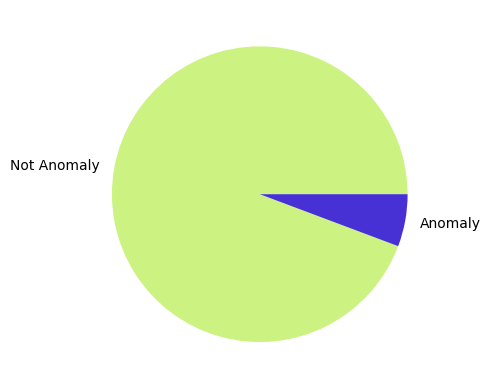

In [7]:
plt.pie( np.bincount(df["Anomaly"]), labels=["Not Anomaly", "Anomaly"], colors=["#CCF381","#4831D4"]);

#### Distribuzione variabili

##### Analogiche

Di seguito viene presentata in modo grafico la distribuzione delle variabili analogiche **`TP2`**, **`TP3`**, **`H1`**, **`DV_pressure`**, **`Reservoirs`**, **`Oil_temperature`** e **`Motor_current`**.

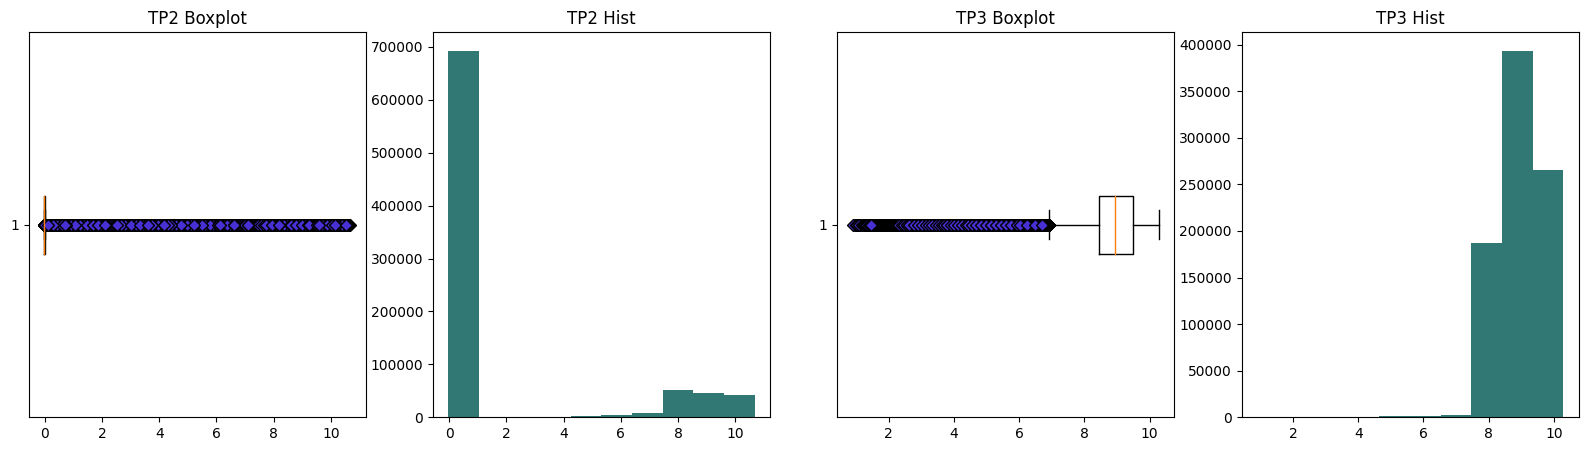

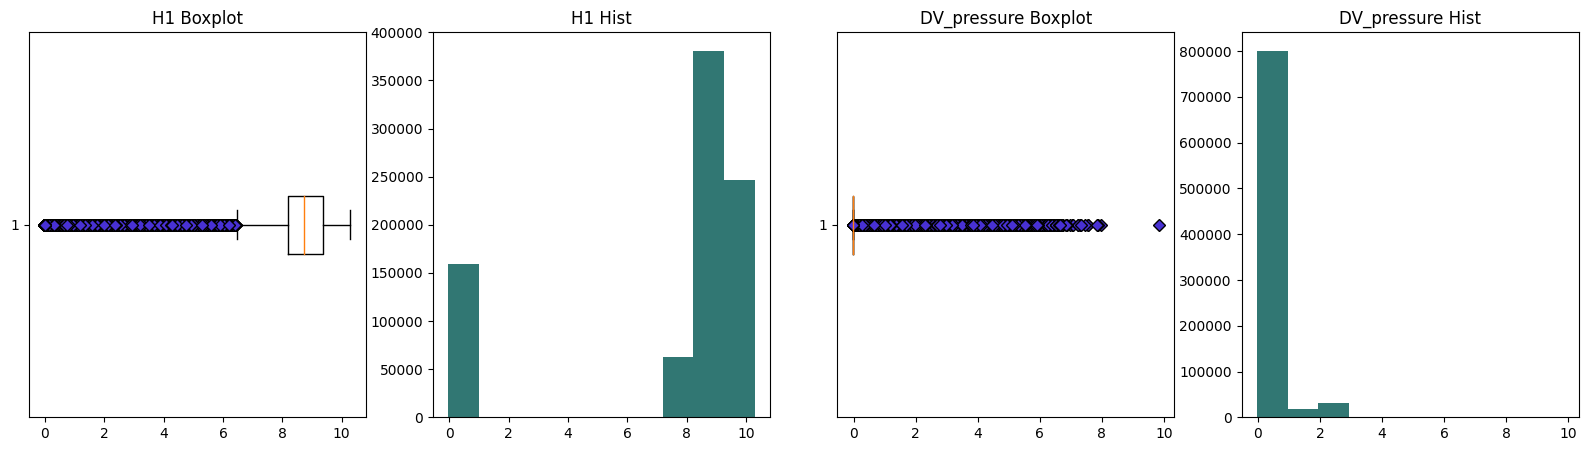

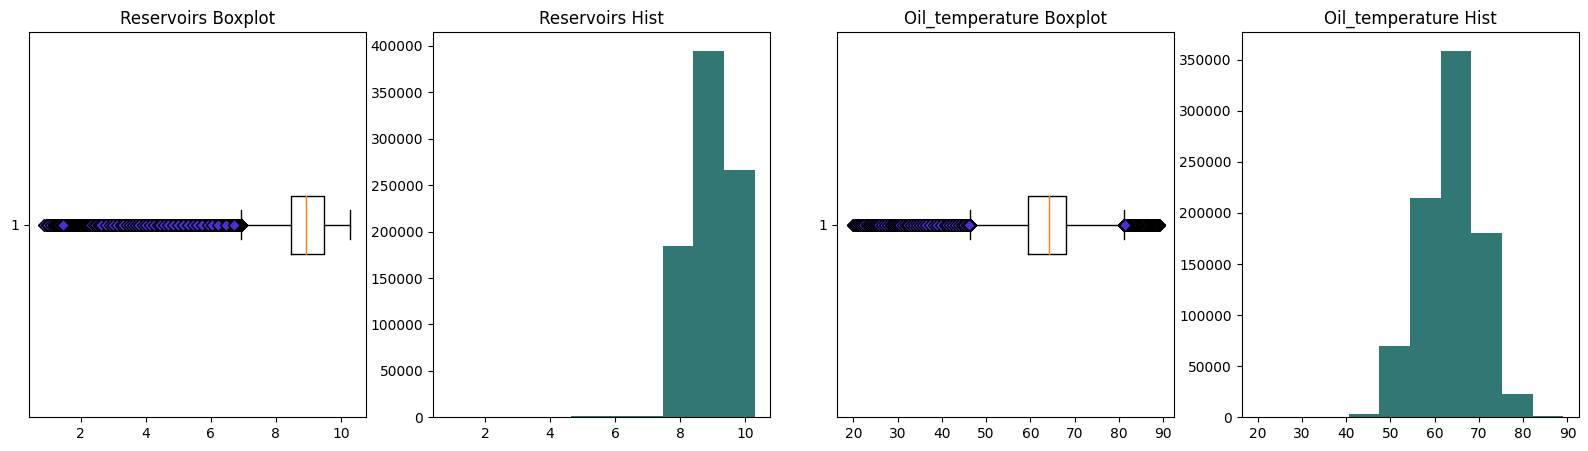

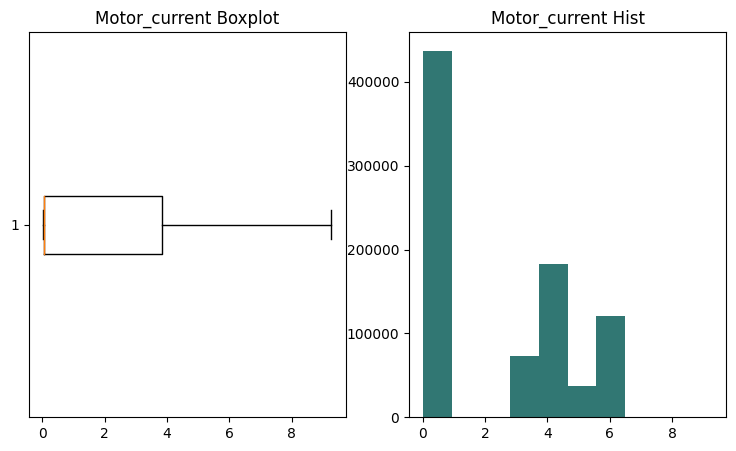

In [8]:
green_diamond = dict(markerfacecolor='#4831D4', marker='D')

for col, col2 in zip(df.columns[:7:2], df.columns[1:8:2]):
    if col2 != "COMP":
        fig, ax = plt.subplots(1,4, figsize=(20,5))
        ax[2].set_title(col2+" Boxplot")
        ax[3].set_title(col2+" Hist")
        ax[2].boxplot(df[col2], flierprops=green_diamond, vert=False )
        ax[3].hist(df[col2], color=["#317773"])
    else:
        fig, ax = plt.subplots(1,2, figsize=(9,5))

    ax[0].set_title(col+" Boxplot")
    ax[1].set_title(col+" Hist")
    ax[0].boxplot(df[col], flierprops=green_diamond, vert=False )
    ax[1].hist(df[col], color=["#317773"])



Come si può notare dagli outliers rappresentati dai rombi color viola, le istanze che si allontanano di molto dalla mediana sono numerose, ci aspettavamo questa distribuzione poichè da definizione le anomalie si discostano dal comportamento normale.</br>
Osserviamo come per i valori assunti da **`TP2`** e **`DV_pressure`** si distinguano piccoli range in cui sono condensati la maggior parte dei valori, per **`TP3`**, **`H1`**, **`Reservoirs`**, **`Oil_temperature`** e **`Motor_current`** invece i valori sono distribuiti in modo più uniforme. </br>Anche in **`H1`** e **`TP2`** sono presenti però range molto densi ma distaccati dalla mediana.

##### Digitali


Di seguito viene presentata in modo grafico la distribuzione delle variabili digitali **`COMP`**, **`DV_eletric`**, **`Towers`**, **`MPG`**, **`LPS`**, **`Pressure Switch`**, **`Oil_level`** e **`Caudal_impulses`**.

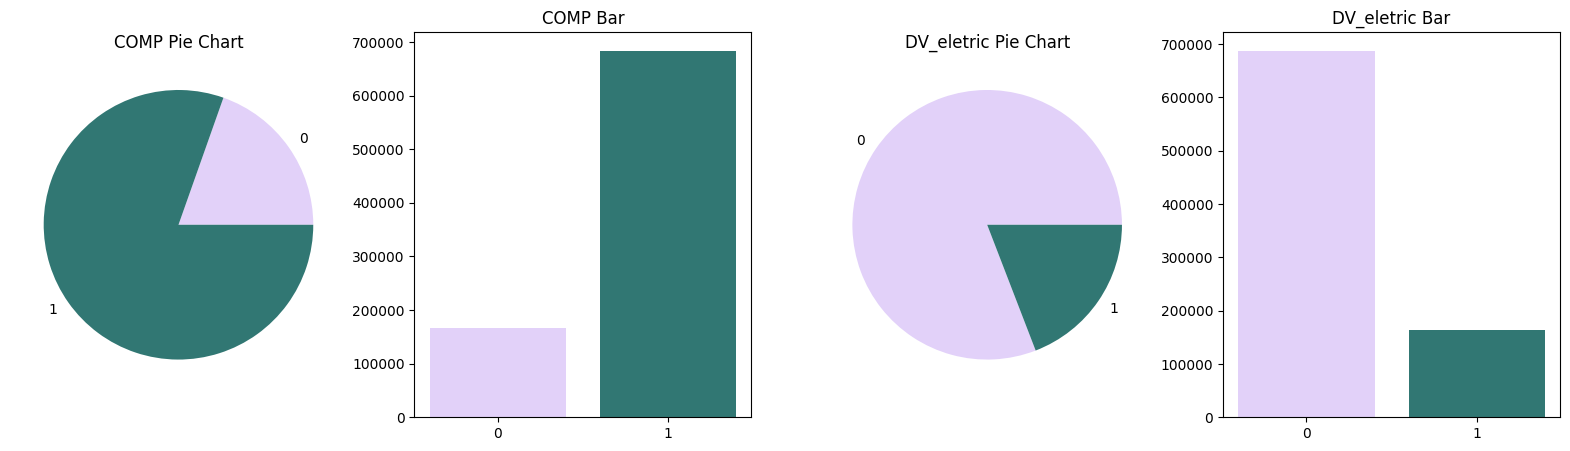

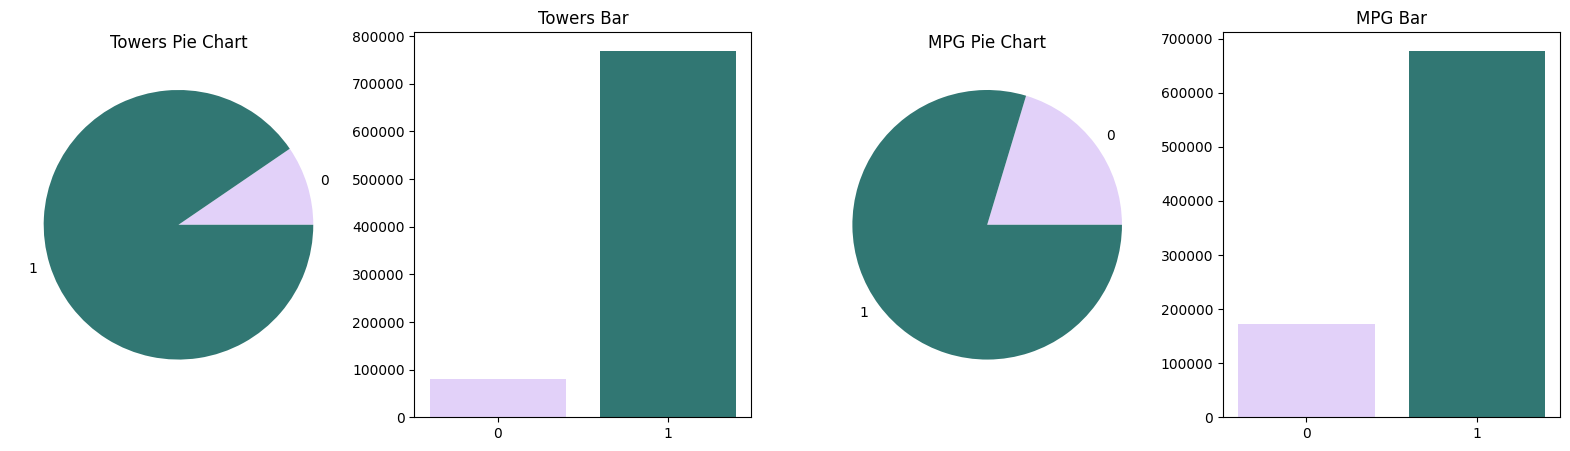

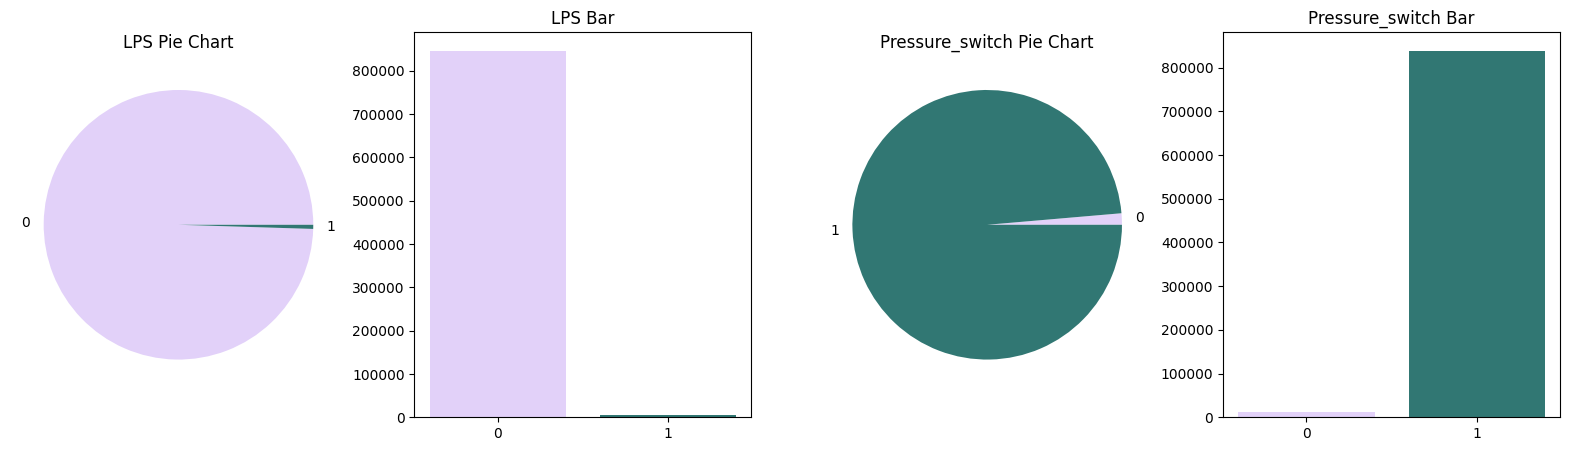

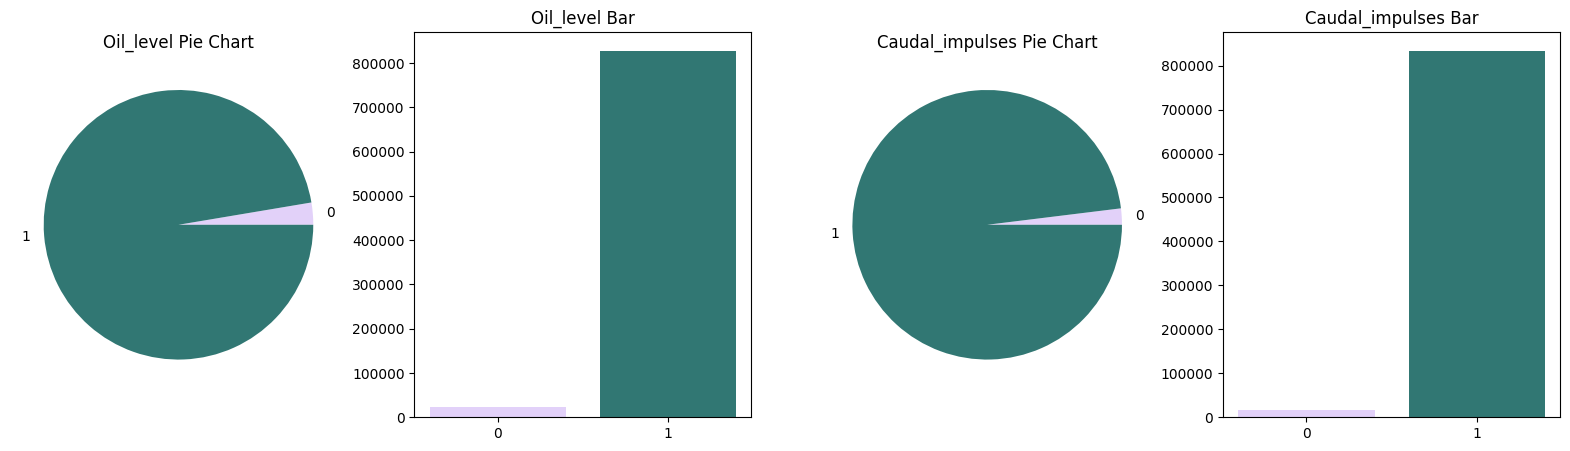

In [9]:
for col, col2 in zip(df.columns[7:15:2], df.columns[8:15:2] ):
    fig, ax = plt.subplots(1,4, figsize=(20,5))
    ax[0].set_title(col+" Pie Chart")
    ax[1].set_title(col+" Bar")
    ax[0].pie( np.bincount(df[col]), labels=["0", "1"], colors=["#E2D1F9","#317773"]);
    ax[1].bar([0, 1], np.bincount(df[col]), color=["#E2D1F9","#317773"])
    ax[1].set_xticks(np.arange(2))
    ax[1].set_xticklabels(['0', '1'])

    ax[2].set_title(col2+" Pie Chart")
    ax[3].set_title(col2+" Bar")
    ax[2].pie( np.bincount(df[col2]), labels=["0", "1"], colors=["#E2D1F9","#317773"]);
    ax[3].bar([0, 1], np.bincount(df[col2]), color=["#E2D1F9","#317773"])
    ax[3].set_xticks(np.arange(2))
    ax[3].set_xticklabels(['0', '1'])

Per tutte le varibili digitali si può notare come uno dei due valori binari prevalga nettamente sull'altro come frequenza. </br>
Nei casi **`COMP`**, **`DV_eletric`**, **`Towers`** e **`MPG`** il rapporto tra i due valori è alto ma quello in minoranza rappresenta comunque una porzione discreta, invece per **`LPS`**, **`Pressure Switch`**, **`Oil_level`** e **`Caudal_impulses`** il rapporto è molto più marcato e la frequenza del secondo valore è estremente più bassa tanto da essere poco significativa per il nostro modello in quanto il valore assunto da queste variabili è praticamente costante.

### Correlazione variabili

Visualizziamo ora una matrice di correlazione che indica per orgni coppia di variabili quale sia il loro indice di correlazione.

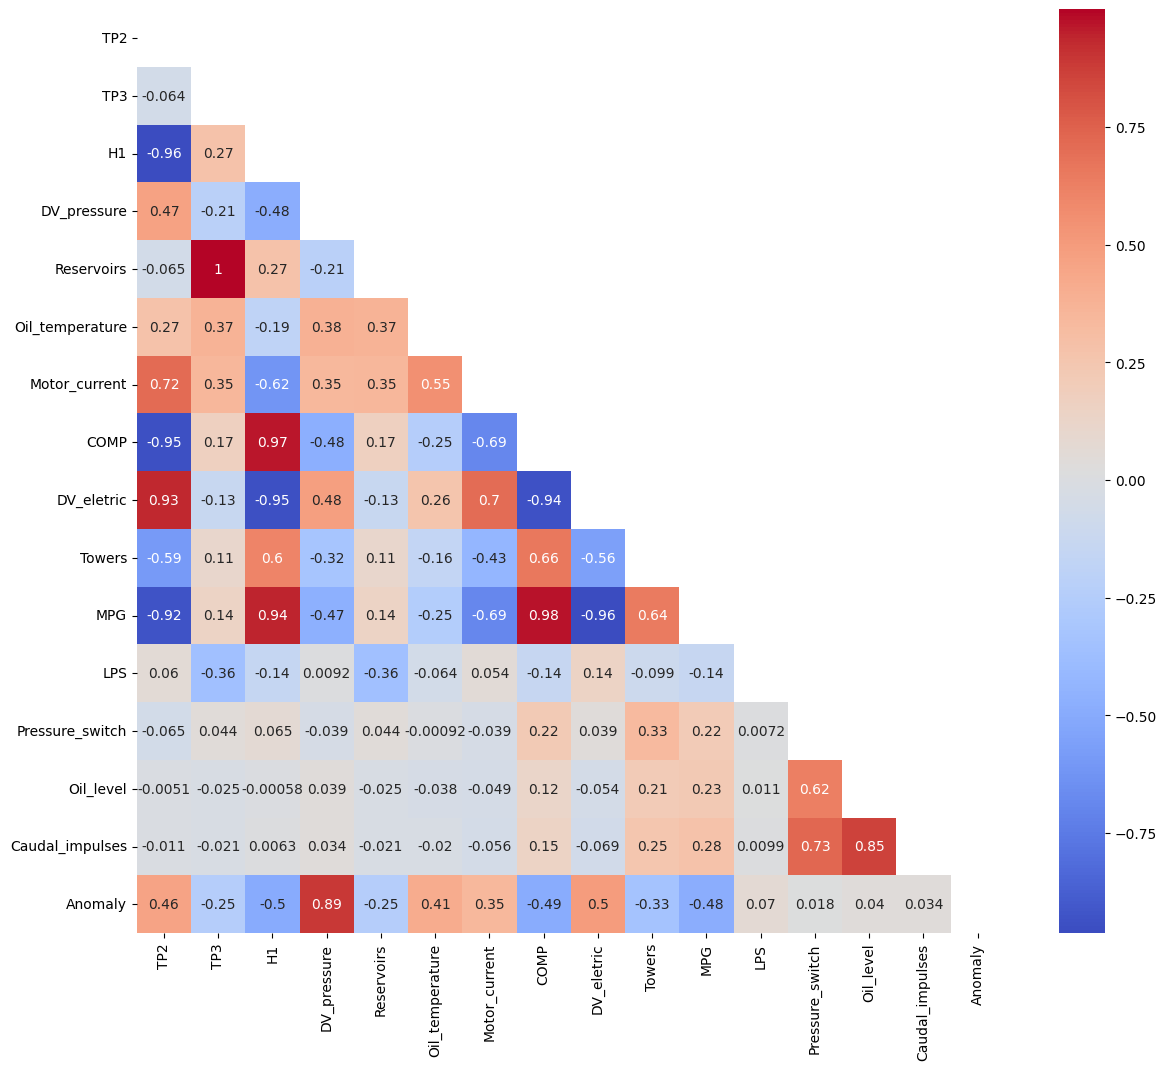

In [10]:
corr_df = df.corr(method='pearson')

plt.figure(figsize=(14, 12))
sns.heatmap(corr_df, annot=True, mask=np.triu(corr_df), cmap='coolwarm')
plt.show()

Si possono fare interessanti osservazioni sull'anomalia che ha una discreta correlazione positiva con gli attributi **`TP2`**, **`DV_pressure`**, **`Oil_temperature`**, **`DV_eletric`**, mentre si riscontra una correlazione negativa con **`COMP`** e **`MPG`**. </br>
La variabile con correlazione maggiore rispetto ad **`Anomaly`** risulta essere **`DV_pressure`** , oltre a essere quella con il valore più alto bisogna anche notare che il suo indice di correlazione è il 78% maggiore rispetto a quello della seconda variabile con indice più alto.</br> **`DV_pressure`** ha quindi buoni presupposti per essere una variabile determinante per i fini del progetto.

### Distribuzione anomalia rispetto alle variabili più significative

#### Analogiche

Distribuzione delle anomalie nei range di valori analogiche assunti dalle variabili più significative del dataset ovvero **`TP2`**, **`H1`**, **`DV_pressure`**, e **`Oil_temperature`**.

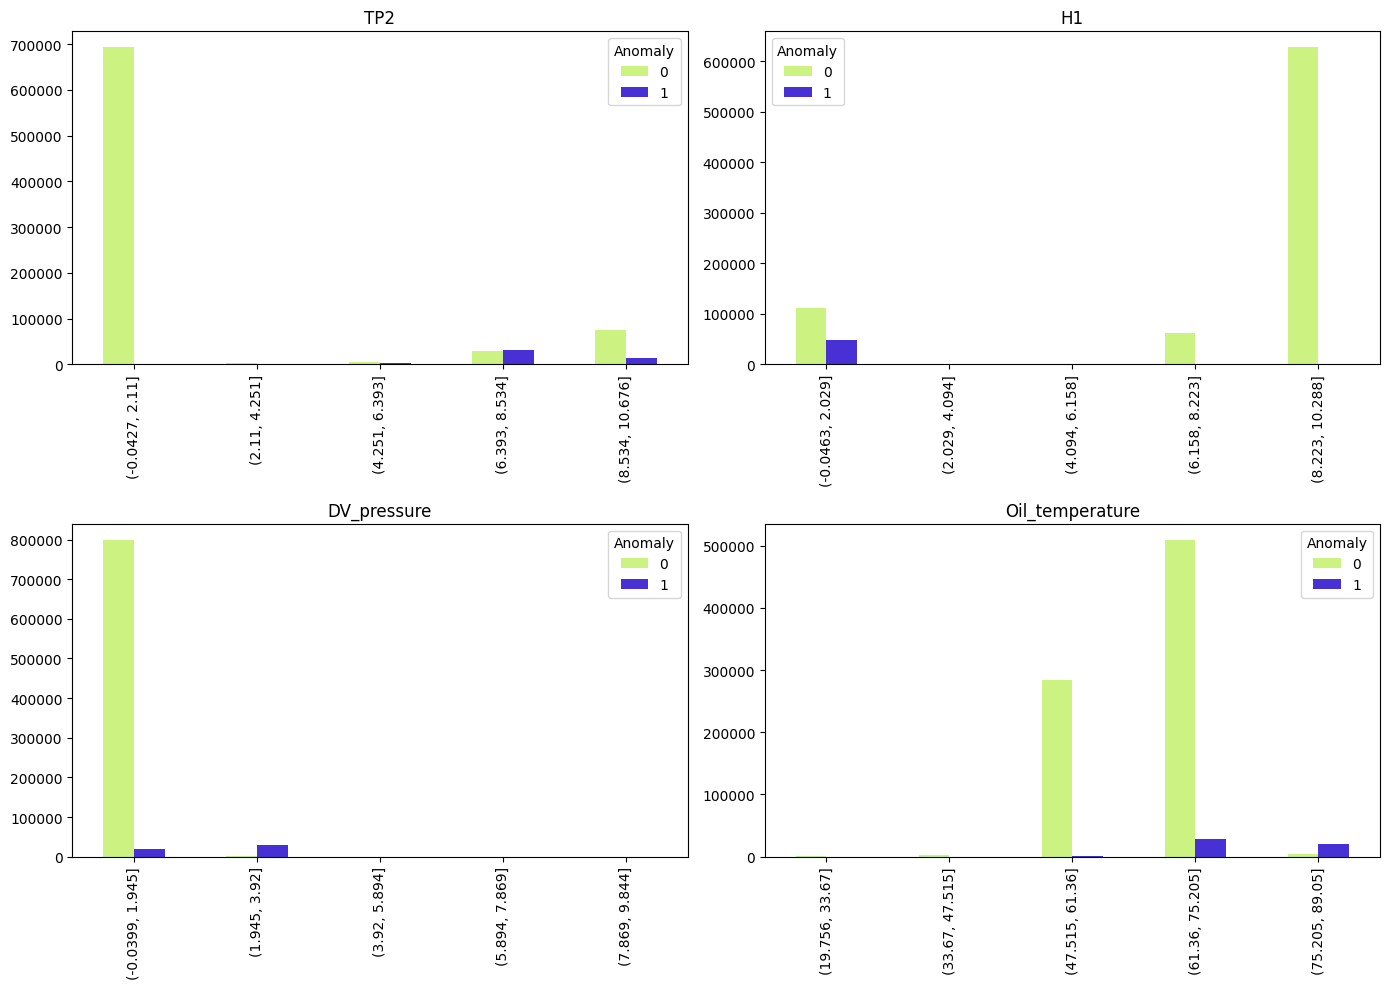

In [11]:
high_corr_analog = ["TP2", "H1", "DV_pressure", "Oil_temperature"]

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

for i, col in enumerate(high_corr_analog):
    bars = df.groupby(  [ pd.cut(df[col], bins=5), "Anomaly" ]  ).size().unstack("Anomaly")
    bars.plot(kind="bar", color=["#CCF381","#4831D4"], ax=axs[i//2, i%2])
    axs[i//2, i%2].set_title(col)
    axs[i//2, i%2].set(xlabel=None)

plt.tight_layout()
plt.show()

Possiamo chiaramente vedere come i casi di Non-anomalia ovvero lo stato normale dei valori sia concentrato per la maggior parte in singoli range di valore per ognuna delle variabili. </br>
Si può anche notare come in generale i casi di anomalie per i valori assunti da queste variabili (che presentano una discreta correlazione con la variabile **`Anomaly`**) risultano essere distribuiti in range circorscritti di valori e per alcuni di questi range il rapporto Anomalia/Non-Anomalia risulta in proporzione nettamente più alto in favore dell'anomalia. </br>
Di conseguenza queste variabili possono essere considerate sufficientemente valide da essere utilizzate per i nostri fini.

#### Digitali

Distribuzione delle anomalie per i valori digitali assunti dalle variabili più significative del dataset ovvero **`COMP`** e **`MPG`**,

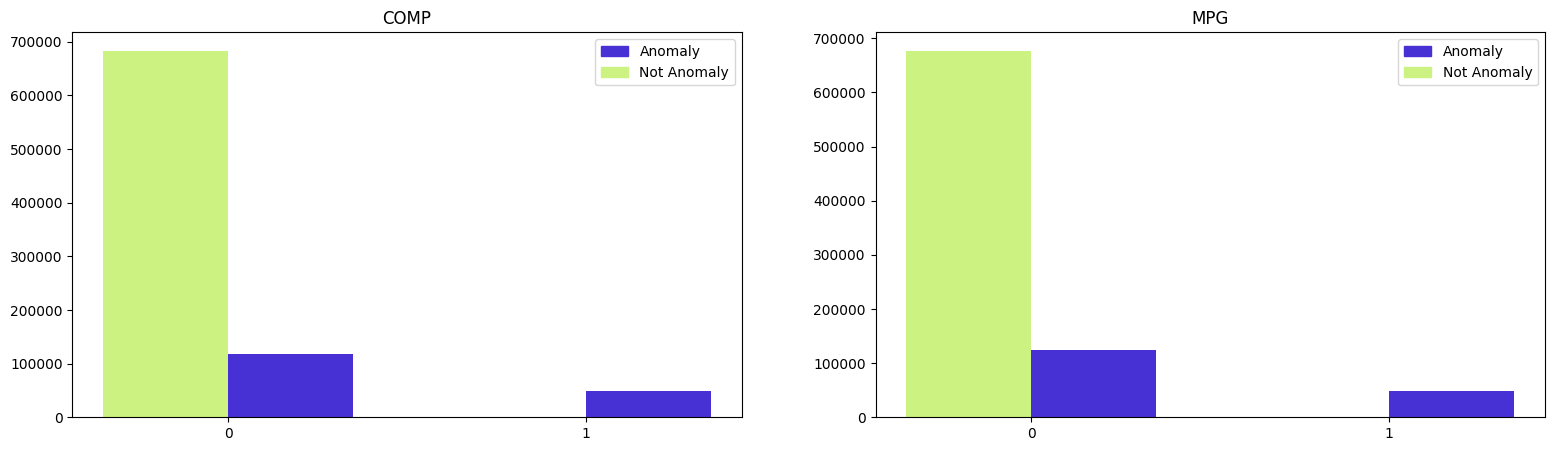

In [12]:
high_corr_digital = ["COMP", "MPG"]
width = 0.35

fig, ax = plt.subplots(1,2, figsize=(19,5))

x_labels = ['0', '1']
x = np.arange(len(x_labels))

for i, col in enumerate(high_corr_digital):
    ax[i].bar(x + width/2, np.bincount(df["Anomaly"][df[col] == 0]), width, color=['#4831D4'])
    ax[i].bar(x - width/2, np.bincount(df["Anomaly"][df[col] == 1]), width, color=['#CCF381'])
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(x_labels)

    colors = { 'Anomaly':'#4831D4', 'Not Anomaly':'#CCF381' }
    labels = list(colors.keys())
    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
    ax[i].legend(handles, labels)
    ax[i].set_title(col)
plt.show()

Dai grafici è intuibile che per entrambi il valore più frequente sia 0, invece al valore 1 che è poco frequente per COMP e MPG in proporzione corrisponde un alto tasso di anomalie. </br>
Per definizione i valori digitali COMP e MPG sono strettamente legati tra loro infatti i grafici sono estremamente simili, ma anche al valore analogico di H1 con cui infatti hanno entrambe una correlazione vicina ad 1.

### Scelta variabili

Le varibili analogiche e digitali rappresentano in molti casi informazioni ridondanti, per questo abbiamo deciso di concentrare l'attenzione su quelle analogiche, che ci offrono maggior variazioni nei valori.
</br>

#### Potenzialità individuazione iperpiano con variabili scelte
Analizziamo quindi come risultano distribuite le istanze con e senza anomalia rispetto a tutte le coppie di varibili analogiche.

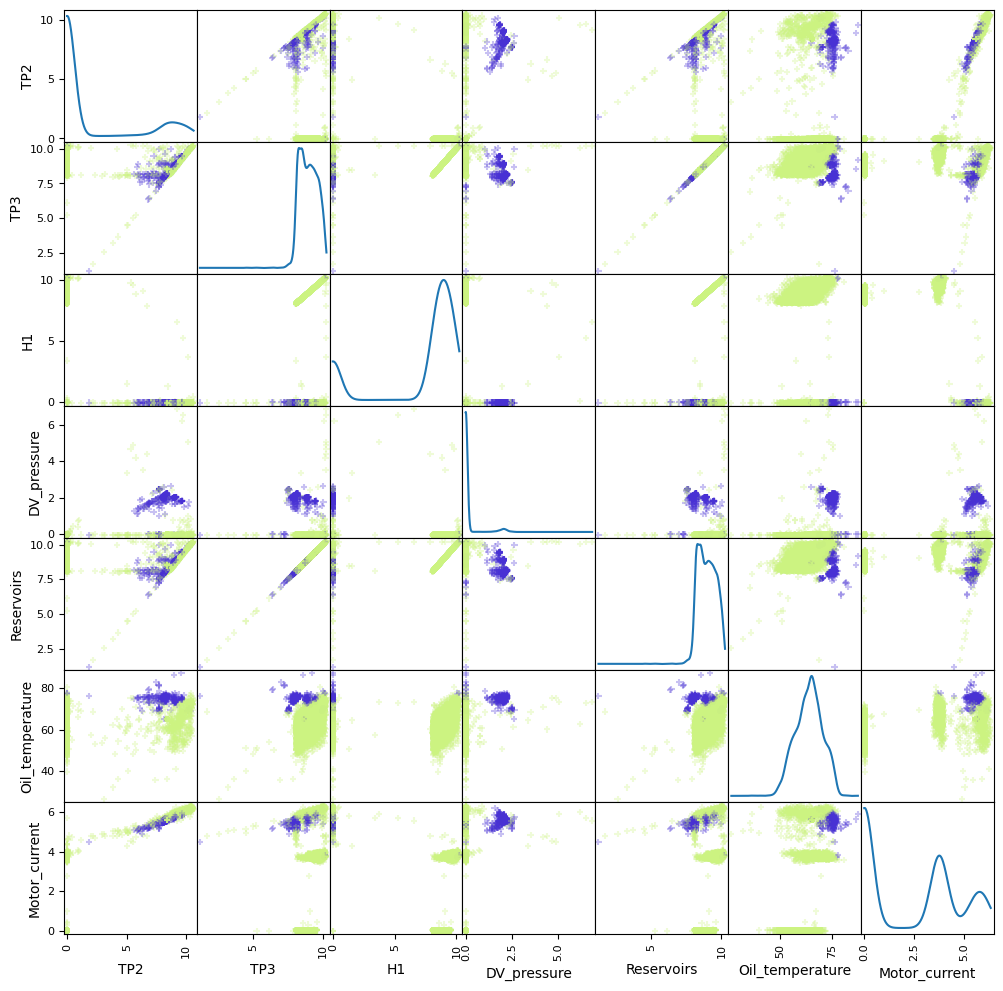

In [13]:
digital = ["COMP", "DV_eletric", "Towers", "MPG", "LPS", "Pressure_switch", "Oil_level", "Caudal_impulses"]

sample = df.sample(5000)

pd.plotting.scatter_matrix(    sample.drop([*digital, "Anomaly"], axis=1),
                               c=sample["Anomaly"].map({0:'#CCF381', 1:'#4831D4'}),
                               alpha=0.3,
                               figsize=(12,12),
                               marker="+",
                               edgecolors=None,
                               s=20,
                               diagonal='kde',
                               hist_kwds={"bins": 10, "color": "#317773"});

Si può notare che nei grafici in cui è coinvolto **`DV_pressure`** la separazione tra le istanze con anomalie risultano chiaramente distaccate dalle altre in modo netto, viene confermata quindi l'osservazione fatta in precedenza sulla correlazione delle variabili con **`Anomaly`** per cui **`DV_pressure`** risultava la più influente.

## Preparazione Dati

### Selezione e Aggiunta di nuove features
 Per una precisione migliore sarebbe meglio non trascurare nessuna delle varibili analogiche poichè nonostante alcune abbiano indici di correlazione con Anomaly nettamente maggiori di altre, lo stato di anomalia potrebbe essere causato da problemi differenti, alcuni più frequenti (riscontrabili in variabili che quindi ottengono rilevanza maggiore) e altri meno, questi ultimi che inevitabilmente hanno meno rilevanza sono comunque influenti per la rappresentazione di tutto lo spettro dei possibili fattori di causa dei una anomalia. </br>
 Per motivi pratici di tempo/risorse e quantità delle variabili in questo notebook utilizziamo solo le variabili più significative che abbiamo descritto e analizzato prededentemente ovvero **`TP2`**, **`H1`**, **`DV_pressure`**, e **`Oil_temperature`**. </br>
 Consideriamo due possibili insiemi di features, uno con le 4 variabili selezionate e un altro in cui oltre alle 4 variabili aggiungiamo **4 nuove feature**: **`TP2_lag1`**, **`H1_lag1`**, **`DV_pressure_lag1`**, e **`Oil_temperature_lag1`** derivate dalle misurazioni precedenti in modo da cercare di ottenere predizioni più affidabili, procederemo valutando inizialmente entrambi gli insiemi di features per poi eleggere il migliore con cui proseguire il progetto.

In [14]:
analog_features_selected = {
    "TP2":              df["TP2"],
    "H1":               df["H1"],
    "DV_pressure":      df["DV_pressure"],
    "Oil_temperature":  df["Oil_temperature"],
}

analog_features_selected_lag1 = {
    "TP2":                      df["TP2"],
    "H1":                       df["H1"],
    "DV_pressure":              df["DV_pressure"],
    "Oil_temperature":          df["Oil_temperature"],

    "TP2_lag1":                 df["TP2"].shift(1),
    "H1_lag1":                  df["H1"].shift(1),
    "DV_pressure_lag1":         df["DV_pressure"].shift(1),
    "Oil_temperature_lag1":     df["Oil_temperature"].shift(1),
}

X0 = pd.DataFrame(analog_features_selected)
X1 = pd.DataFrame(analog_features_selected_lag1)[1:]

y0 = df["Anomaly"].astype(np.uint8)
y1 = df["Anomaly"].astype(np.uint8)[1:]

Dovendo ridurre il numero di istanza per motivi pratici dovuti al tempo di training dei modelli e dato che il dataset è estremamente sbilanciato abbiamo optato per un intervallo di tempo che avesse una percentuale di anomalie leggermente maggiore, in questo del 7.5%, effettuando quindi una operazione di **oversampling**.




In [15]:
def split_train_val(X, y):
    period = X.index.month == 5
    period &= X.index.day >= 28
    period &= X.index.day <= 31
    X_train, X_val, y_train, y_val = train_test_split(
        X.loc[period],
        y.loc[period],
        test_size=1/3, random_state=42
    )

    X_train.index.isin(X_val.index).sum()

    y_val.value_counts(normalize=True)
    return X_train, X_val, y_train, y_val

X0_train, X0_val, y0_train, y0_val = split_train_val(X0, y0)
X1_train, X1_val, y1_train, y1_val = split_train_val(X1, y1)

print("Percentuale di anomalie dopo oversampling: {:.3f}".format( pd.concat([y1_train, y1_val]).describe()["mean"] ))


Percentuale di anomalie dopo oversampling: 0.074


Passiamo quindi da circa il 5.7% di anomalie a circa il 7.4% ovvero un incremento del 30%.

## Addestramento, Validazione e Ricerca Iperparametri

### Cross-validation
Per la cross validation utilizziamo Stratified K-Fold poichè più indicato rispetto a K-Fold per quanto rigurda classi sbilanciate come nel nostro caso.

In [16]:
skf = StratifiedKFold(3, shuffle=True, random_state=42)

Costruiamo dei metodi per effettuare Cross-Validation, allenamento e valutazione dei modelli.


In [17]:
def gs_describe(gs, score, X_train, y_train):
    pd.DataFrame(gs.cv_results_).sort_values("rank_test_score").head(5)

    print("Score on validation:         {}".format(score))
    print("Score on train:              {}".format(gs.score(X_train, y_train))) # per controllo overfitting/underfitting
    print("Cross validation best score: {}".format(gs.best_score_))
    print("Best hyperparameters:    \n\n{}\n".format(pd.Series(gs.best_params_)))

def grid_search_Xvalidation(model, grid, kf, X_train, X_val, y_train, y_val):
    gs = GridSearchCV(model, grid, cv=kf)
    gs.fit(X_train, y_train)
    score = gs.score(X_val, y_val)

    return gs, score

### Modelli scelti


Abbiamo selezionato 5 modelli di classificazione con caratteristiche differenti, da Perceptron utilizzato come modello di base fino ad una maggiore complessità come con XGBoost:
</br>
- Perceptron
- Logistic Regression
- SVM
- Random Forest
- XGBClassifier



Salviamo tutti i modelli allenati e il loro score per poi confrontarli.

In [18]:
models = {}

### Addestramento e ricerca Iperparametri

Effettuiamo la fase di allenamento e ricerca iperparametri per Perceptron con entrambi gli insiemi di features individuati in precedenza. </br>
In questo notebook sono stati mantenuti dei sottoinsiemi di iperparametri contenenti quelli risultati migliori in esplorazioni più approfondite che sono stati omessi per praticità dovuti ai tempi di esecuzione.

### Perceptron

In [19]:
model = Pipeline([
    ("scaler",      StandardScaler()),
    ("perceptron",  Perceptron())
])

grid = {
    "scaler":                     [None, StandardScaler()],
    "perceptron__penalty":        ["l2", "l1", "elasticnet"],
    "perceptron__alpha":          np.logspace(-3, 3, 7),
    "perceptron__fit_intercept":  [False, True]
}

In [20]:
%%time

gs0, score = grid_search_Xvalidation(model, grid, skf, X0_train, X0_val, y0_train, y0_val)
gs_describe(gs0, score, X0_train, y0_train)
y0_pred = gs0.best_estimator_.predict(X0_val)
print("Report:\n", classification_report(y0_val, y0_pred, digits=6), "\n")
print("Model coefficients: \n{}\n".format(pd.Series(gs0.best_estimator_.named_steps["perceptron"].coef_[0], index=X0_train.columns)))

Score on validation:         0.9956624233851956
Score on train:              0.995473406261788
Cross validation best score: 0.9966050880293656
Best hyperparameters:    

perceptron__alpha                       0.001
perceptron__fit_intercept                True
perceptron__penalty                        l1
scaler                       StandardScaler()
dtype: object

Report:
               precision    recall  f1-score   support

           0   0.999389  0.995938  0.997660      9848
           1   0.949431  0.992074  0.970284       757

    accuracy                       0.995662     10605
   macro avg   0.974410  0.994006  0.983972     10605
weighted avg   0.995823  0.995662  0.995706     10605
 

Model coefficients: 
TP2                 0.000000
H1                 -0.464660
DV_pressure         4.997538
Oil_temperature    12.441334
dtype: float64

CPU times: user 8.58 s, sys: 6.29 s, total: 14.9 s
Wall time: 9.16 s


In [21]:
%%time

gs1, score = grid_search_Xvalidation(model, grid, skf, X1_train, X1_val, y1_train, y1_val)
gs_describe(gs1, score, X1_train, y1_train)
y1_pred = gs1.best_estimator_.predict(X1_val)
print("Report:\n", classification_report(y1_val, y1_pred, digits=6), "\n")
print("Model coefficients: \n{}\n".format(pd.Series(gs1.best_estimator_.named_steps["perceptron"].coef_[0], index=X1_train.columns)))

Score on validation:         0.9962281942479962
Score on train:              0.995850622406639
Cross validation best score: 0.9942946569175439
Best hyperparameters:    

perceptron__alpha            0.001
perceptron__fit_intercept    False
perceptron__penalty             l1
scaler                        None
dtype: object

Report:
               precision    recall  f1-score   support

           0   0.999186  0.996751  0.997967      9848
           1   0.959027  0.989432  0.973992       757

    accuracy                       0.996228     10605
   macro avg   0.979106  0.993091  0.985979     10605
weighted avg   0.996319  0.996228  0.996255     10605
 

Model coefficients: 
TP2                    -1056.978
H1                      -849.566
DV_pressure             1918.338
Oil_temperature         -140.805
TP2_lag1                -337.118
H1_lag1                 -989.076
DV_pressure_lag1        1796.032
Oil_temperature_lag1     208.655
dtype: float64

CPU times: user 10.2 s, sys: 7.35 s,

Dai coefficienti attribuiti alle variabili del primo modello si nota come le più influenti siano **`DV_pressure`** e **`Oil_temperature`** come ci si poteva aspettare dalle analisi effettuate precedentemente.</br>
Si può osservare che nel secondo modello le variabili con lag hanno una forte influenza, in certi casi anche maggiore della rispettiva senza lag, inoltre **`TP2`** e **`H1`** assumono più rilevanza. </br>

#### Features migliori

In base ai risultati ottenuti con il Perceptron che è un modello basico valutiamo di continuare l'esplorazione degli altri modelli più complessi utilizzando l'insieme di features che hanno riscontrato degli score migliori per il fine del nostro progetto, ovvero **`analog_features_selected_lag1`**. </br>
Conserviamo quindi solo il Perceptron allenato con le features scelte.

In [22]:
models["Perceptron"] = { "model": gs1.best_estimator_, "score": score }

X_train, X_val, y_train, y_val = X1_train, X1_val, y1_train, y1_val

#### Visualizzazione di un possibile iperpiano di seperazione

Plottiamo le istanze colorate per Anomalia/Non-anomalia considerando solo due variabili di forte interesse quali **`DV_pressure`** e **`Oil_temperature`** e addestriamo il modello Percetron precedentemente creato (senza sovrescrivere quello memorizzato) solamente su queste due in modo da poter visualizzare un ipotetico iperpiano che evidenzi una possibile separazione delle due classi.

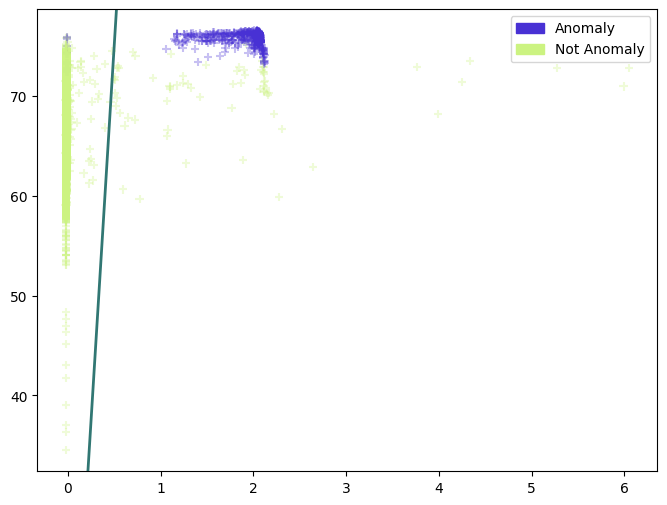

In [23]:
diagnosis_color_map = {0:'#CCF381', 1:'#4831D4'}

def separator_2d(model, x1):
    w = model.coef_[0]
    b = model.intercept_[0]
    return -x1 * w[0] / w[1] - b / w[1]

def plot_separator_on_data(X, y, model=None):
    X = np.array(X)
    colors = pd.Series(y).map(diagnosis_color_map)
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=colors, alpha=0.3, marker="+", s=35)
    if model is not None:
        xlim, ylim = plt.xlim(), plt.ylim()
        sep_x = np.linspace(*xlim, 2)
        sep_y = separator_2d(model, sep_x)
        plt.plot(sep_x, sep_y, c="#317773", linewidth=2)
        plt.xlim(xlim); plt.ylim(ylim)

        colors = { 'Anomaly':'#4831D4', 'Not Anomaly':'#CCF381' }
        labels = list(colors.keys())
        handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
        plt.legend(handles, labels)

model = deepcopy( models["Perceptron"]["model"].named_steps["perceptron"] )
model.fit(X1_train.loc[:, ["DV_pressure","Oil_temperature"]], y1_train)
plot_separator_on_data(X1_val.loc[:, ["DV_pressure","Oil_temperature"]], y1_val, model)

Risulta chiaro che la divisione individuata da questo iperpiano è molto netta e quindi particolarmente significativa.

### Logistic Regression

In [24]:
%%time

model = Pipeline([
    ("scaler",  StandardScaler()),
    ("logreg",  LogisticRegression(max_iter=200))
])

grid = {
    "scaler":           [None, StandardScaler()],
    "logreg__penalty":  ["l2", "l1"],
    "logreg__C":        [1, 0.8, 0.3],
    "logreg__solver":   ["liblinear"]
}

gs, score = grid_search_Xvalidation(model, grid, skf, X_train, X_val, y_train, y_val)
gs_describe(gs, score, X_train, y_train)

models["Logistic Regression"] = { "model": gs.best_estimator_, "score": score }

Score on validation:         0.9992456388495993
Score on train:              0.9990098076197661
Cross validation best score: 0.9988683448907912
Best hyperparameters:    

logreg__C                       0.8
logreg__penalty                  l1
logreg__solver            liblinear
scaler             StandardScaler()
dtype: object

CPU times: user 36.6 s, sys: 2.42 s, total: 39.1 s
Wall time: 37.3 s


### SVM

In [25]:
%%time

model = Pipeline([
    ("scaler",  StandardScaler()),
    ("svc",     SVC())
])

grid = {
    'svc__C':       np.logspace(3, 5, 3),
    'svc__gamma':   ['scale', 'auto'],
    'svc__kernel':  ['rbf', 'linear']
}

gs, score = grid_search_Xvalidation(model, grid, skf, X_train, X_val, y_train, y_val)
gs_describe(gs, score, X_train, y_train)

models["SVC"] = { "model": gs.best_estimator_, "score": score }

Score on validation:         0.998962753418199
Score on train:              0.9997170878913617
Cross validation best score: 0.9991040894199155
Best hyperparameters:    

svc__C         10000.0
svc__gamma       scale
svc__kernel        rbf
dtype: object

CPU times: user 2min 3s, sys: 221 ms, total: 2min 4s
Wall time: 2min 13s


### Random Forest

In [26]:
%%time

model = Pipeline([
    ("scaler",        StandardScaler()),
    ("randomforest",  RandomForestClassifier(n_jobs=-1, random_state=42))
])

num_features = X_train.columns.size

grid = {
    "scaler":                           [None, StandardScaler()],
    'randomforest__n_estimators':       range(5, 10),
    'randomforest__min_samples_split':  range(2, 5),
    'randomforest__max_depth':          [None] + [i for i in range(1, 3)],
    'randomforest__max_features':       [int(math.sqrt(num_features)), num_features - 1]
}

gs, score = grid_search_Xvalidation(model, grid, skf, X_train, X_val, y_train, y_val)
gs_describe(gs, score, X_train, y_train)

models["Random Forest"] = { "model": gs.best_estimator_, "score": score}

Score on validation:         0.9994342291371995
Score on train:              0.9999528479818937
Cross validation best score: 0.9994341824498315
Best hyperparameters:    

randomforest__max_depth                        None
randomforest__max_features                        2
randomforest__min_samples_split                   4
randomforest__n_estimators                        7
scaler                             StandardScaler()
dtype: object

CPU times: user 16.6 s, sys: 1.33 s, total: 18 s
Wall time: 43.4 s


### XGBoost

In [27]:
%%time

model = Pipeline([
    ("scaler",  StandardScaler()),
    ("xgb",     XGBClassifier(objective="reg:squarederror"))
])

grid = {
    'xgb__eta':           [0.001, 0.002, 0.1],
    'xgb__max_depth':     [6, 9, 13],
    'xgb__n_estimators':  [150, 300],
    'xgb__alpha':         [0.0001, 0.001]
}

gs, score = grid_search_Xvalidation(model, grid, skf, X_train, X_val, y_train, y_val)
gs_describe(gs, score, X_train, y_train)

models["XGBoost"] = { "model": gs.best_estimator_, "score": score }

Score on validation:         0.9991513437057992
Score on train:              1.0
Cross validation best score: 0.9991984379207074
Best hyperparameters:    

xgb__alpha             0.0001
xgb__eta               0.1000
xgb__max_depth         6.0000
xgb__n_estimators    150.0000
dtype: float64

CPU times: user 5min 27s, sys: 1.2 s, total: 5min 28s
Wall time: 3min 4s


Ecco un recap degli score ottenuti dai modelli.

In [28]:
for model in models:
    print("{:<20}:\t{:.6f}".format(model, models[model]["score"]))

Perceptron          :	0.996228
Logistic Regression :	0.999246
SVC                 :	0.998963
Random Forest       :	0.999434
XGBoost             :	0.999151


## Validazione e Valutazione modelli



In questa sezione analizzeremo Accuracy, Precision, Recall, F1 score, matrice di confusione per ogni modello.

Dato che le classi sono sbilanciate, l'**accuracy diventa un indicatore non attendibile** quindi visualizziamo anche misurazioni più profonde come Precision(0-1), Recall(0-1) e F1-Measure(0-1).

PERCEPTRON 

Precision score: 0.9590268886043534
Recall score:    0.9894319682959049
F1 Score:        0.9859794253851593

Report:
               precision    recall  f1-score   support

           0   0.999186  0.996751  0.997967      9848
           1   0.959027  0.989432  0.973992       757

    accuracy                       0.996228     10605
   macro avg   0.979106  0.993091  0.985979     10605
weighted avg   0.996319  0.996228  0.996255     10605
 



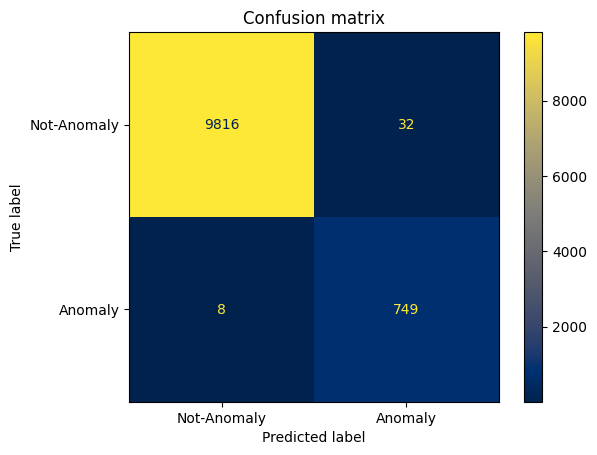



____________________________________________________________________________________________________


LOGISTIC REGRESSION 

Precision score: 0.99734395750332
Recall score:    0.9920739762219286
F1 Score:        0.9971479476922042

Report:
               precision    recall  f1-score   support

           0   0.999391  0.999797  0.999594      9848
           1   0.997344  0.992074  0.994702       757

    accuracy                       0.999246     10605
   macro avg   0.998367  0.995935  0.997148     10605
weighted avg   0.999245  0.999246  0.999245     10605
 



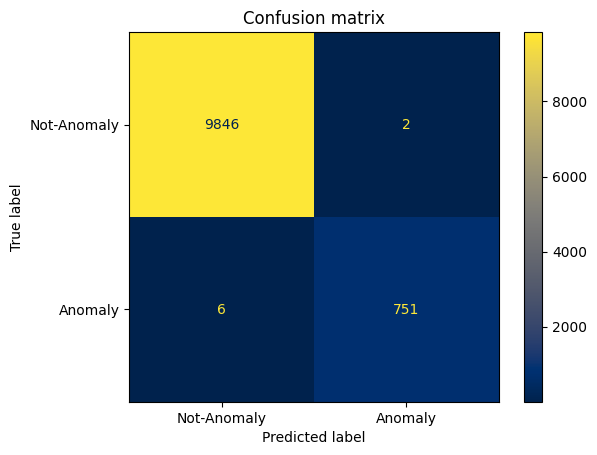



____________________________________________________________________________________________________


SVC 

Precision score: 0.9933862433862434
Recall score:    0.9920739762219286
F1 Score:        0.9960856077304139

Report:
               precision    recall  f1-score   support

           0   0.999391  0.999492  0.999442      9848
           1   0.993386  0.992074  0.992730       757

    accuracy                       0.998963     10605
   macro avg   0.996389  0.995783  0.996086     10605
weighted avg   0.998962  0.998963  0.998962     10605
 



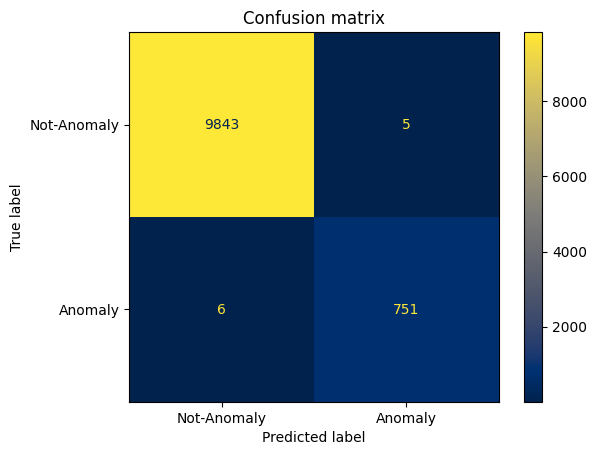



____________________________________________________________________________________________________


RANDOM FOREST 

Precision score: 0.9960369881109643
Recall score:    0.9960369881109643
F1 Score:        0.9978661788645804

Report:
               precision    recall  f1-score   support

           0   0.999695  0.999695  0.999695      9848
           1   0.996037  0.996037  0.996037       757

    accuracy                       0.999434     10605
   macro avg   0.997866  0.997866  0.997866     10605
weighted avg   0.999434  0.999434  0.999434     10605
 



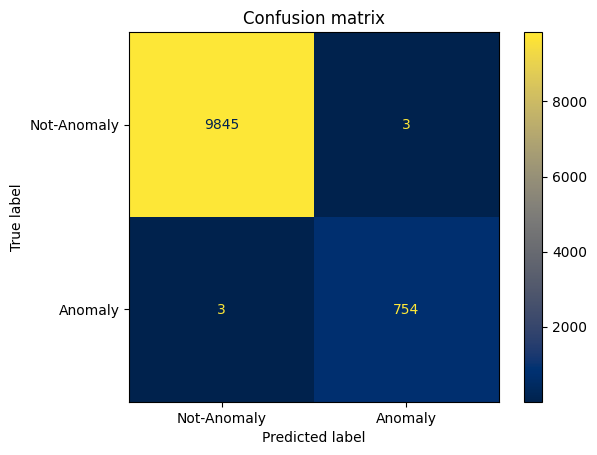



____________________________________________________________________________________________________


XGBOOST 

Precision score: 0.9960212201591512
Recall score:    0.9920739762219286
F1 Score:        0.9967934018493886

Report:
               precision    recall  f1-score   support

           0   0.999391  0.999695  0.999543      9848
           1   0.996021  0.992074  0.994044       757

    accuracy                       0.999151     10605
   macro avg   0.997706  0.995885  0.996793     10605
weighted avg   0.999150  0.999151  0.999151     10605
 



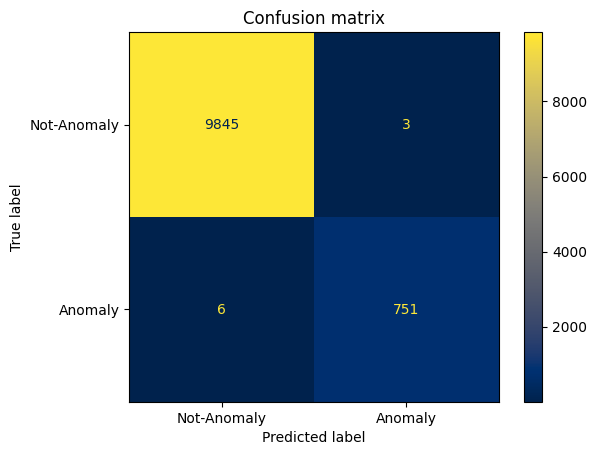



____________________________________________________________________________________________________




In [34]:
for model in models:
    print(model.upper(), "\n")
    m = models[model]["model"]
    y_pred = m.predict(X_val)
    f1 = f1_score(y_val, y_pred, average="macro")
    models[model]["F1"] = f1

    print("Precision score: {}".format(precision_score(y_val, y_pred)))
    print("Recall score:    {}".format(recall_score(y_val, y_pred)))
    print("F1 Score:        {}\n".format(f1))
    print("Report:\n", classification_report(y_val, y_pred, digits=6), "\n")
    disp = ConfusionMatrixDisplay.from_predictions(y_val, y_pred, cmap='cividis', display_labels=["Not-Anomaly","Anomaly"])
    plt.title("Confusion matrix")
    plt.show()
    print("\n")
    print("_"*100)
    print("\n")

Per il nostro task di rilevazione delle anomalie dovremmo indirizzare la scelta del modello in base all'utilizzo specifico che dovrà essere fatto, ci interessano particolarmente Precision e Recall relativi al valore 1 di Anomaly poichè sono questi l'obbiettivo principale, infatti il modello sarebbe inutile se riconoscesse perfettamente gli stati di Non-anomalia e non riuscisse a riconoscere una anomalia quando si presenta. </br>
Nel contesto della manutenzione potremmo considerare più importante il valore di Precision in quanto per questo scopo, in generale è più desiderabile un Falso-Positivo piuttosto che un Falso-negativo tenendo conto di un trade-off favorevole per ad esempio Costo di Controllo in officina del treno per prevenire la rottura di un componente rispetto al Costo causato dalla effettiva rottura del componente. </br>
Invece sarebbe più utile considerare il valore di Recall se ad esempio l'allarme generato dal modello per la rilevazione di una anomalia comportasse procedure con costi molto alti rispetto a quelli necessari per una riparazione e quindi da limitare il più possibile.
</br>
Ovviamente sono valutazioni molto sottili che non possono essere fatta a priori senza un preciso contesto di applicazione.

#### Controllo differenza statistica tra i modelli

In [30]:
def check_statistic_diff_between_models(e1, e2, conf):
    z = stats.norm.ppf(conf)
    diff = abs(e1 - e2)
    margin = z * math.sqrt((((1 - e1) * e1) / len(y_val)) + (((1 - e2) * e2) / len(y_val)))
    lower = diff - margin
    upper = diff + margin
    print("Min: {:.6f}\tMax: {:.6f}\n".format(lower, upper))

alpha = 0.95
exclude = ["Perceptron"]

for key1, model1 in enumerate(models):
    for key2, model2 in enumerate(models):
        if key2 > key1 and model1 not in exclude and model2 not in exclude:
            err1 = 1 - models[model1]["F1"]
            err2 = 1 - models[model2]["F1"]
            print("{} vs {}".format(model1, model2))
            check_statistic_diff_between_models(err1, err2, alpha)

Logistic Regression vs SVC
Min: -0.000249	Max: 0.002374

Logistic Regression vs Random Forest
Min: -0.000408	Max: 0.001845

Logistic Regression vs XGBoost
Min: -0.000887	Max: 0.001596

SVC vs Random Forest
Min: 0.000540	Max: 0.003021

SVC vs XGBoost
Min: -0.000638	Max: 0.002053

Random Forest vs XGBoost
Min: -0.000093	Max: 0.002238



La differenza tra SVC⟺Random Forest è l'unica ad essere statisticamente significativa poichè l'intervallo risultante non contiene lo zero.</br>
Tutte le altre coppie di modelli invece non hanno una differenza che sia statisticamente significativa.</br>

In [33]:
model = DummyClassifier(strategy="uniform")
model.fit(X_train, y_train)
score = model.score(X_val, y_val)

predict = model.predict(X_val)
print(classification_report(y_val, predict, digits=5))

              precision    recall  f1-score   support

           0    0.92748   0.51300   0.66061      9848
           1    0.07018   0.47820   0.12240       757

    accuracy                        0.51051     10605
   macro avg    0.49883   0.49560   0.39150     10605
weighted avg    0.86629   0.51051   0.62219     10605



È interessante notare come il modello "Dummy" riesca ad ottenere un'accuracy del 51%, che sottolinea quanto rimarcato in precedenza ovvero che essa non sia un indicatore affidabile per classi sbilanciate come queste. </br>
Con questa analisi approfondita su **Precision(1)**, **Recall(1)** e **F1-measure(1)** si evince che sia stato in grado di classificare correttamente le anomalie solo per pura casualità, infatti la percentuale è praticamente uguale a quella della percentuale di anomalie del dataset, per cui le predizioni del modello quando si verifica un'anomalia sarebbero estremamente insufficienti per il nostro scopo.

#### Scelta modello finale
Scegliamo quindi Random Forest per i seguenti motivi:

|     Fattore          |    Risultato   |
| ------------- | -------- |
| Score generale migliore |    0.999434   |
| Misura di Precision rispetto ad Anomaly = 1|    0.996037    |
| Misura di Recall rispetto ad Anomaly = 1	|  0.996037 |
| Misura di F1-measure rispetto ad Anomaly = 1 	|    0.996037    |
| Interpretabilità  | Possibilità di analizzare i Decision Tree generati |

##### Visualizzazione Decision Tree
Visualizziamo uno dei Decision Tree generati da Random Forest, è possibile visualizzare anche gli altri modificando il valore della variabile T nella seguente cella.

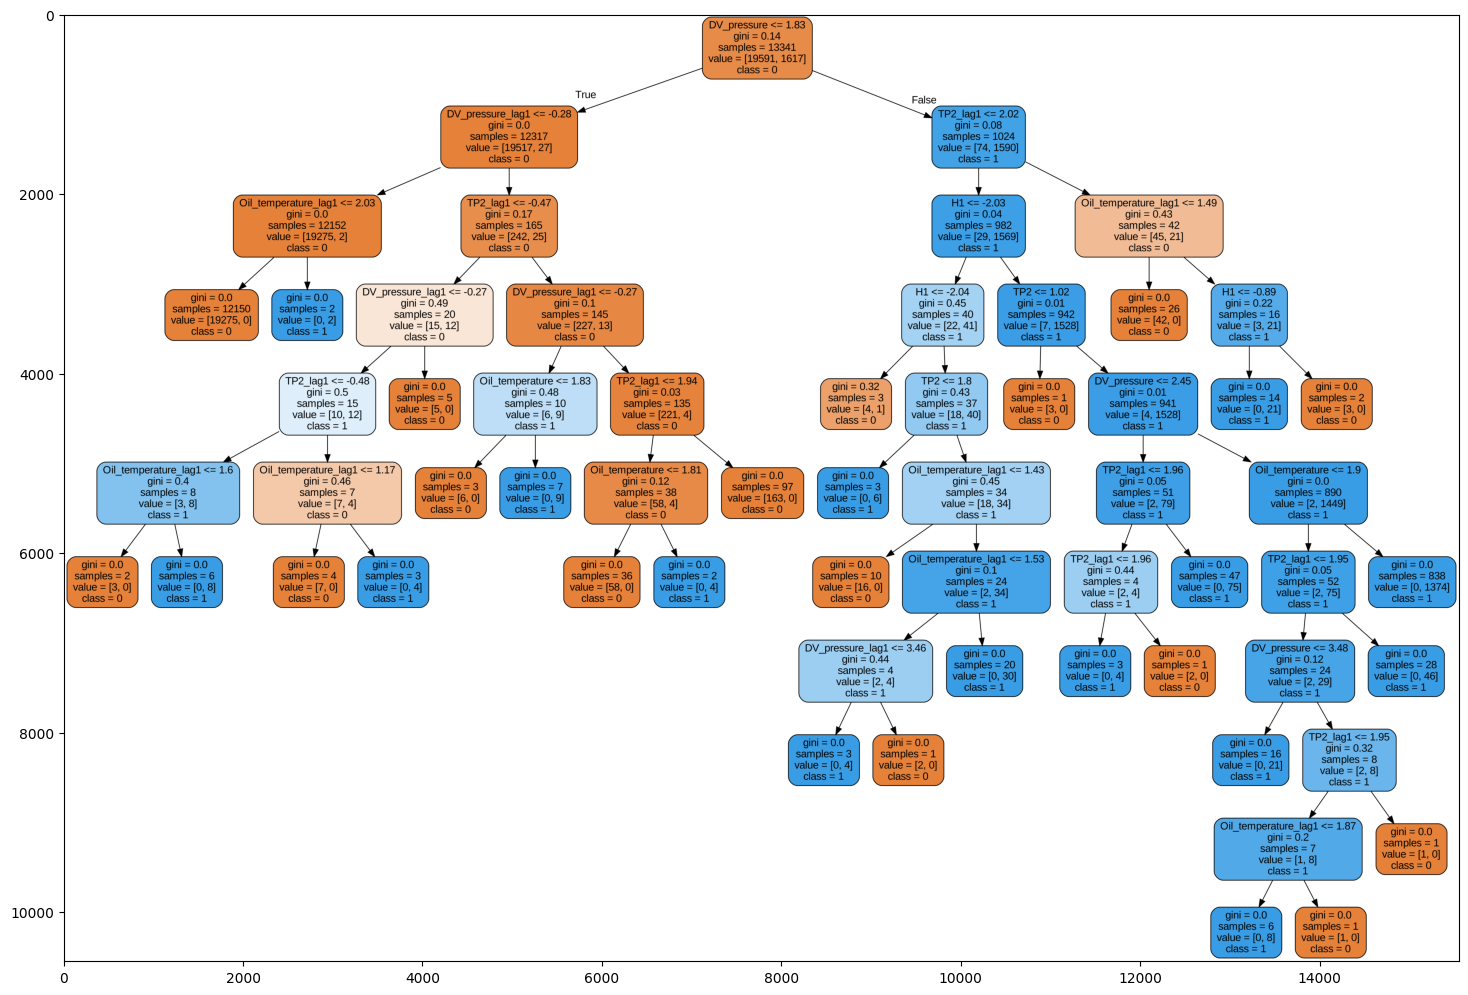

In [32]:
# indice Decision Tree da visualizzare, possibilità di scegliere nel range [0-8]
T = 3

model_rf = models["Random Forest"]["model"].named_steps["randomforest"]

estimator = model_rf.estimators_[T]
export_graphviz(estimator, out_file='tree.dot',
                feature_names = X_train.columns,
                class_names = ['0','1'],
                rounded = True, proportion = False,
                precision = 2, filled = True)
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600']);

img = matplotlib.image.imread('tree.png')
plt.figure(figsize=(18,18));
plt.imshow(img);

Come da tesi **`DV_pressure`** risulta essere il più determinante nei primi nodi di questo albero di decisione.

## Considerazioni finali

Nonostante un dataset con classi sbilanciate siamo riusciti ad ottenere un modello finale in grado di classificare con un margine di errore accettabile le situazioni di Anomalia della Air Production Unit presa in considerazione utilizzando solamente i dati relativi a 4 sensori e 4 features da essi derivate. </br>
Tramite la valutazione dei modelli siamo riusciti a confermare tutte le assunzioni descritte nella fase di analisi esplorativa.